In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')

In [5]:
#req1 = req1[20000:2005000]
#gen_req1 = gen_req1[20000:2005000]
req1.shape,gen_req1.shape

((2005000,), (2255000,))

In [6]:
N = 100 # total ids 
pi = 3.14

LRU

In [8]:
def LRU(y, x, request_time,con):
  [N,I] = x.shape
  J = len(y)
  old = y.reshape(J*N).copy()
  for j in range(J):
    x_t_j = np.zeros((N),int)
    file_req_time = np.zeros((N),int)

    # to find which users are connected to this cache 
    connected_users = []
    for k in range(I):
      if con[k,j] == 1:
        connected_users.append(k)
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
      file_req_time = np.maximum(file_req_time, request_time[:,connected_users[k]])
    x_t_j = np.minimum(np.ones(N),x_t_j)

    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))# file which is not requested but still in the cache
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) # file requested but not in the cache.
    a = np.sum(a1)
    b = np.sum(b1)

    if a>0 and b>0:
      if a>b:
        ind = []
        for k in range(N):
          if a1[k] == 1:
            ind.append(k)
        t = np.zeros(a)
        for k in range(a):
          t[k] = file_req_time[ind[k]]
        replace = (t).argsort()[:b]
        for k in range(b):
          y[j,ind[int(replace[k])]] = 0
        for k in range(N):
          if b1[k] == 1:
            y[j,k] = 1
      
      else:
        for k in range(N):
          if a1[k] == 1:
            y[j,k] = 0
        ind = []
        for k in range(N):
          if b1[k] == 1:
            ind.append(k)
        for k in range(a):
          y[j,ind[k]] = 1
  new = y.reshape(J*N)
  download = np.sum(np.logical_and(new,np.logical_not(old)))
  return y,download

LFU

In [9]:
def LFU(y,x,freq,con):
  [N,I] = x.shape
  J = len(y)
  old = y.reshape(J*N).copy()
  for j in range(J):
    file_freq = np.zeros((N),int)
    x_t_j = np.zeros((N),int)

    # to find which users are connected to this cache 
    connected_users = []
    for k in range(I):
      if con[k,j] == 1:
        connected_users.append(k)
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
      file_freq += freq[:,connected_users[k]]
    x_t_j = np.minimum(np.ones(N),x_t_j)

    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))# file which is not requested but still in the cache
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) # file requested but not in the cache.
    a = np.sum(a1)
    b = np.sum(b1)
  
    if a>0 and b>0:
      if a>b:
        ind = []
        for k in range(N):
          if a1[k] == 1:
            ind.append(k)
        t = np.zeros(a)
        for k in range(a):
          t[k] = file_freq[ind[k]]
        replace = (t).argsort()[:b]
        for k in range(b):
          y[j,ind[int(replace[k])]] = 0
        for k in range(N):
          if b1[k] == 1:
            y[j,k] = 1
      else:
        for k in range(N):
          if a1[k] == 1:
            y[j,k] = 0
        ind = []
        for k in range(N):
          if b1[k] == 1:
            ind.append(k)
        for k in range(a):
          y[j,ind[k]] = 1
  new = y.reshape(J*N)
  download = np.sum(np.logical_and(new,np.logical_not(old)))
  return y,download

perturbed count

In [10]:
def per_count(eta,count):
  [N,I] = count.shape
  p_count = np.zeros((N,I),dtype = 'f4')
  for i in range(I):
    p_count[:,i] = count[:,i] + np.round(np.multiply(eta, random.normal(0,1,[N,1])).reshape(N),4)
  return p_count

GREEDY

In [16]:
def Greedy(con,count):
  [I,J] = con.shape
  [N,I] = count.shape
  load = np.zeros((1,J),dtype = int)

  for i in range(I):
    for f in range(N):
      if count[f,i] < 0:
        count[f,i] = 0
  
  loadc = 0
  y = np.zeros((J,N),dtype = int)
  z = np.zeros((I,N),dtype = 'f4')
  mark = np.zeros((I,N),dtype = int)

  while(loadc < J):
    best_cache = -1
    best_file = -1
    best_imp = -1

    for j in range(J):
      if load[0,j] < C:
        for f in range(N):
          if y[j,f] != 1:
            imp = 0

            for i in range(I):
              if con[i,j] == 1 and mark[i,f] == 0:
                imp += count[f,i]

            if imp >= best_imp:
              best_cache = j
              best_file = f
              best_imp = imp

    y[best_cache,best_file] = 1

    for i in range(I):
      if con[i,best_cache] == 1:
        mark[i,best_cache] = 1

    load[0,best_cache] += 1
    if load[0,best_cache] == C:
      loadc += 1
  
  for i in range(I):
    for f in range(N):
      for j in range(J):
        if con[i,j] == 1:
          z[i,f] = np.maximum(y[j,f],z[i,f])
      
  return y,z

SINGLE CACHE

In [12]:
I = 1 #users
T = 100000
degree = 1
J = 1 #caches
C = 5
connection = np.array([[1]])
connection.shape

(1, 1)

In [13]:
req = req1[:I*T].reshape(I,T)
req

array([[17, 80, 26, ..., 69, 34, 83]])

In [14]:
gen_req = gen_req1[:I*T].reshape(I,T)
gen_req

array([[17, 80, 26, ..., 64, 79, 87]])

In [27]:
y_LRU = np.zeros((J,N),dtype = int)
y_LFU = np.zeros((J,N),dtype = int)
y_FTPL = np.zeros((J,N),dtype = int)
y_LSTM = np.zeros((J,N),dtype = int)
y_LSTM[:,:C] = np.ones((J,C),dtype = int)
y_FTPL[:,:C] = np.ones((J,C),dtype = int)
y_LRU[:,:C] = np.ones((J,C),dtype = int)
y_LFU[:,:C] = np.ones((J,C),dtype = int)
count = np.zeros((N,I),dtype = int)
reward_LSTM =  np.zeros((T),int)
reward_FTPL =  np.zeros((T),int)
reward_LRU =  np.zeros((T),int)
reward_LFU =  np.zeros((T),int)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
FTPL_downloads_slotwise = np.zeros((T),int)
LFU_downloads_slotwise = np.zeros((T),int)
LRU_downloads_slotwise = np.zeros((T),int)
LSTM_downloads_slotwise = np.zeros((T),int)
req_time = np.zeros((N,I),dtype = int) 
req_time1 = np.zeros((N,I),dtype = int) 

for t in range(T):
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros((I),int)
  ireward_LSTM =  np.zeros((I),int)
  ireward_LFU =  np.zeros((I),int)
  ireward_FTPL =  np.zeros((I),int)
  
  for i in range(I):
    temp1 = np.zeros((N),int)
    temp2 = np.zeros((N),int)
    temp3 = np.zeros((N),int)
    temp4 = np.zeros((N),int)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)

  [y_LFU,LFU_downloads_slotwise[t]] = LFU(y_LFU,x_t,count,connection)
  [y_LRU,LRU_downloads_slotwise[t]] = LRU(y_LRU,x_t,req_time,connection)
  [y_LSTM,LSTM_downloads_slotwise[t]] = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = round(I*pow(4*pi*np.log(N*I),-.25)*pow((t+1)/(J*degree*C),.5),4)
  perturbed_count=per_count(eta,count)
  old_FTPL = y_FTPL.reshape(J*N)
  add = (-perturbed_count[:,0]).argsort()[:C]
  y_FTPL = np.zeros((J,N),dtype = int)
  for k in range(len(add)):
    y_FTPL[0,int(add[k])] = 1 
  new_FTPL = y_FTPL.reshape(J*N)
  FTPL_downloads_slotwise[t] = (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
 
  download_FTPL.append(np.sum(FTPL_downloads_slotwise))
  download_LFU.append(np.sum(LFU_downloads_slotwise))
  download_LRU.append(np.sum(LRU_downloads_slotwise))
  download_LSTM.append(np.sum(LSTM_downloads_slotwise))

  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %10000 == 0:
    print(t,download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t],hits_FTPL[t],hits_LFU[t],hits_LRU[t],hits_LSTM[t])

0 5 1 1 1 0 0 0 0
10000 36884 9397 9477 9477 581 604 524 524
20000 63480 18715 18994 18994 1264 1286 1007 1007
30000 85350 28029 28465 27616 1916 1972 1536 2385
40000 102428 37355 37919 36214 2613 2646 2082 3787
50000 117480 46740 47407 44815 3261 3261 2594 5186
60000 130383 56073 56865 53412 3963 3928 3136 6589
70000 141662 65392 66324 62018 4681 4609 3677 7983
80000 152436 74733 75808 70578 5382 5268 4193 9423
90000 162123 84087 85340 79217 6063 5914 4661 10784


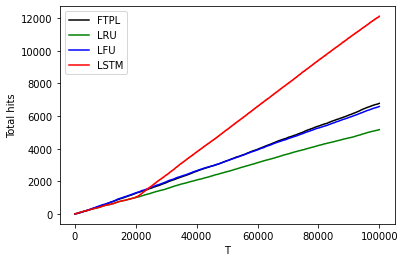

In [28]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('Total hits')
plt.legend()
plt.savefig('Total hits(I=J=1).png')

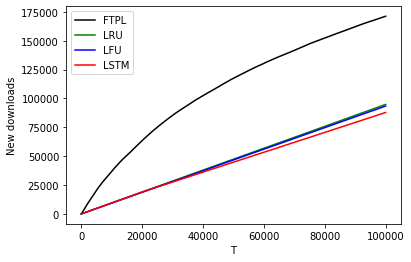

In [29]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('New downloads')
plt.legend()
plt.savefig('New downloads(I=J=1).png')

I = 5 J = 3 d = 3

In [30]:
C = 5
I = 5
J = 3
degree = 3
T = 30000

In [31]:
connection = np.zeros((I,J),dtype = int)
i = 0
for j in range(J):
  x = 0
  while x < degree:
    connection[i,j] = 1
    x += 1
    i += 1
    if i == I:
      i = 0
connection

array([[1, 1, 0],
       [1, 0, 1],
       [1, 0, 1],
       [0, 1, 1],
       [0, 1, 0]])

In [32]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')
req1 = req1[20000:]
gen_req1 = gen_req1[20000:]

In [33]:
req = req1.reshape(I,-1)
req.shape

(5, 397000)

In [34]:
gen_req = gen_req1.reshape(I,-1)
gen_req.shape

(5, 447000)

In [37]:
y_LRU = np.zeros((J,N),dtype = int)
y_LFU = np.zeros((J,N),dtype = int)
y_FTPL = np.zeros((J,N),dtype = int)
y_LSTM = np.zeros((J,N),dtype = int)
y_LSTM[:,:C] = np.ones((J,C),dtype = int)
y_FTPL[:,:C] = np.ones((J,C),dtype = int)
y_LRU[:,:C] = np.ones((J,C),dtype = int)
y_LFU[:,:C] = np.ones((J,C),dtype = int)
count = np.zeros((N,I),dtype = int)
reward_LSTM =  np.zeros((T),int)
reward_FTPL =  np.zeros((T),int)
reward_LRU =  np.zeros((T),int)
reward_LFU =  np.zeros((T),int)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
FTPL_downloads_slotwise = np.zeros((T),int)
LFU_downloads_slotwise = np.zeros((T),int)
LRU_downloads_slotwise = np.zeros((T),int)
LSTM_downloads_slotwise = np.zeros((T),int)
req_time = np.zeros((N,I),dtype = int) 
req_time1 = np.zeros((N,I),dtype = int) 

for t in range(T):
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros((I),int)
  ireward_LSTM =  np.zeros((I),int)
  ireward_LFU =  np.zeros((I),int)
  ireward_FTPL =  np.zeros((I),int)
  
  for i in range(I):
    temp1 = np.zeros((N),int)
    temp2 = np.zeros((N),int)
    temp3 = np.zeros((N),int)
    temp4 = np.zeros((N),int)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)

  [y_LFU,LFU_downloads_slotwise[t]] = LFU(y_LFU,x_t,count,connection)
  [y_LRU,LRU_downloads_slotwise[t]] = LRU(y_LRU,x_t,req_time,connection)
  [y_LSTM,LSTM_downloads_slotwise[t]] = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = round(I*pow(4*pi*np.log(N*I),-.25)*pow((t+1)/(J*degree*C),.5),4)
  perturbed_count=per_count(eta,count)
  old_FTPL = y_FTPL.reshape(J*N).copy()
  [y_FTPL,Z] = Greedy(connection,perturbed_count) 
  new_FTPL = y_FTPL.reshape(J*N).copy()
  FTPL_downloads_slotwise[t] = (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
 
  download_FTPL.append(np.sum(FTPL_downloads_slotwise))
  download_LFU.append(np.sum(LFU_downloads_slotwise))
  download_LRU.append(np.sum(LRU_downloads_slotwise))
  download_LSTM.append(np.sum(LSTM_downloads_slotwise))

  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %1000 == 0:
    print(t,download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t],hits_FTPL[t],hits_LFU[t],hits_LRU[t],hits_LSTM[t])

0 15 9 9 8 0 0 0 0
1000 13247 8437 8469 7895 400 374 362 634
2000 26047 16792 16909 15702 834 802 735 1302
3000 38233 25204 25332 23453 1274 1160 1118 2014
4000 50119 33591 33809 31031 1716 1538 1458 2760
5000 61572 41969 42253 38715 2128 1925 1820 3436
6000 72650 50354 50743 46447 2616 2311 2154 4172
7000 82848 58705 59182 54194 3079 2708 2512 4877
8000 92352 67061 67586 61930 3550 3122 2900 5592
9000 101366 75447 76026 69427 3995 3532 3265 6406
10000 109781 83765 84413 77284 4447 3991 3649 7037
11000 117557 92089 92861 85040 4912 4432 4015 7724
12000 124900 100503 101317 92785 5331 4820 4360 8412
13000 132121 108823 109734 100266 5779 5222 4752 9218
14000 139179 117218 118201 108003 6186 5578 5101 9919
15000 146233 125610 126670 115746 6591 5941 5447 10631
16000 153066 134034 135166 123515 6978 6281 5787 11294
17000 159816 142430 143630 130994 7403 6613 6118 12101
18000 166475 150851 152112 138785 7832 6989 6470 12785
19000 173026 159217 160555 146585 8235 7397 6836 13459
20000 17925

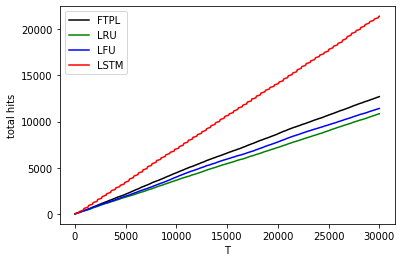

In [38]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('total hits')
plt.legend()
plt.savefig('Total hits(I=5 J=3 d=3).png')

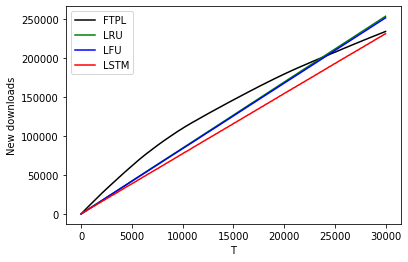

In [39]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('New downloads')
plt.legend()
plt.savefig('New downloads(I=5 J=3 d=3).png')

I = 15 J = 10 d = 7

In [45]:
I = 15
J = 10
C = 15
degree = 7
T = 20000

In [46]:
connection = np.zeros((I,J),dtype = int)
i = 0
for j in range(J):
  x = 0
  while x < degree:
    connection[i,j] = 1
    x += 1
    i += 1
    if i == I:
      i = 0
connection

array([[1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
       [1, 0, 1, 0, 1, 0, 0, 1, 0, 1],
       [1, 0, 1, 0, 0, 1, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 1, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 1, 0]])

In [47]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')
req1 = req1[20000:2004995]
gen_req1 = gen_req1[20000:]

In [48]:
req = req1.reshape(I,-1)
req.shape

(15, 132333)

In [49]:
gen_req = gen_req1.reshape(I,-1)
gen_req.shape

(15, 149000)

In [50]:
y_LRU = np.zeros((J,N),dtype = int)
y_LFU = np.zeros((J,N),dtype = int)
y_FTPL = np.zeros((J,N),dtype = int)
y_LSTM = np.zeros((J,N),dtype = int)
y_LSTM[:,:C] = np.ones((J,C),dtype = int)
y_FTPL[:,:C] = np.ones((J,C),dtype = int)
y_LRU[:,:C] = np.ones((J,C),dtype = int)
y_LFU[:,:C] = np.ones((J,C),dtype = int)
count = np.zeros((N,I),dtype = int)
reward_LSTM =  np.zeros((T),int)
reward_FTPL =  np.zeros((T),int)
reward_LRU =  np.zeros((T),int)
reward_LFU =  np.zeros((T),int)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
FTPL_downloads_slotwise = np.zeros((T),int)
LFU_downloads_slotwise = np.zeros((T),int)
LRU_downloads_slotwise = np.zeros((T),int)
LSTM_downloads_slotwise = np.zeros((T),int)
req_time = np.zeros((N,I),dtype = int) 
req_time1 = np.zeros((N,I),dtype = int) 

for t in range(T):
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros((I),int)
  ireward_LSTM =  np.zeros((I),int)
  ireward_LFU =  np.zeros((I),int)
  ireward_FTPL =  np.zeros((I),int)
  
  for i in range(I):
    temp1 = np.zeros((N),int)
    temp2 = np.zeros((N),int)
    temp3 = np.zeros((N),int)
    temp4 = np.zeros((N),int)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)

  [y_LFU,LFU_downloads_slotwise[t]] = LFU(y_LFU,x_t,count,connection)
  [y_LRU,LRU_downloads_slotwise[t]] = LRU(y_LRU,x_t,req_time,connection)
  [y_LSTM,LSTM_downloads_slotwise[t]] = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = round(I*pow(4*pi*np.log(N*I),-.25)*pow((t+1)/(J*degree*C),.5),4)
  perturbed_count=per_count(eta,count)
  old_FTPL = y_FTPL.reshape(J*N)
  [y_FTPL,Z] = Greedy(connection,perturbed_count) 
  new_FTPL = y_FTPL.reshape(J*N)
  FTPL_downloads_slotwise[t] = (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
 
  download_FTPL.append(np.sum(FTPL_downloads_slotwise))
  download_LFU.append(np.sum(LFU_downloads_slotwise))
  download_LRU.append(np.sum(LRU_downloads_slotwise))
  download_LSTM.append(np.sum(LSTM_downloads_slotwise))

  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %1000 == 0:
    print(t,download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t],hits_FTPL[t],hits_LFU[t],hits_LRU[t],hits_LSTM[t])

0 145 69 69 60 0 0 0 1
1000 93150 56658 57762 54507 4827 4202 3720 4090
2000 167314 112825 114933 108696 9509 8199 7593 8154
3000 230008 168770 172400 162787 14045 12141 11348 12159
4000 286449 225047 230170 217096 18308 15906 15065 16148
5000 338989 280848 287279 271710 22425 19753 18937 20111
6000 388333 336661 344800 325573 26635 23591 22721 24252
7000 434530 392392 402076 379537 30734 27292 26524 28324
8000 479536 448006 459238 433823 34691 30978 30319 32435
9000 521986 503559 516480 487798 38760 34730 34186 36562
10000 562833 559648 573858 541778 42626 38342 37999 40667
11000 603734 615257 631181 595904 46570 42051 41813 44732
12000 643515 670994 688397 650114 50476 45718 45646 48723
13000 682823 726642 745816 704100 54329 49371 49443 52849
14000 720915 782775 803199 757960 58208 53013 53266 56972
15000 758228 838992 861059 812272 62080 56613 56929 61018
16000 795396 895458 918956 866173 65934 60137 60609 65105
17000 831038 951129 976439 920199 69753 63911 64416 69166
18000 866034

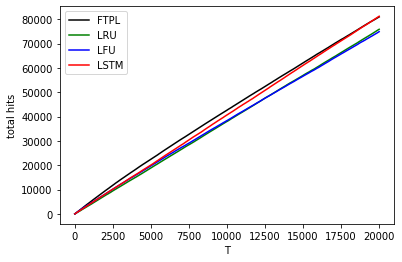

In [51]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('total hits')
plt.legend()
plt.savefig('Total hits(I=15 J=10 d=7).png')

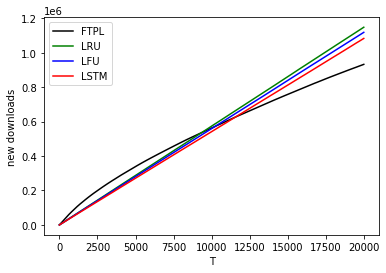

In [52]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('new downloads')
plt.legend()
plt.savefig('New downloads(I=15 J=10 d=7).png')